1. procitati fajl
2. proveriti da li ima signala u svim kanalima
3. proveriti da li je doslo do saturacije u nekom kanalu
4. digitalno filtriranje
5. eliminisanje spajkova
6. naci maksimum pika
7. naci pocetak pika

In [1]:
from numba import jit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
f = open('c:\DRS4 2013.04.26 22pf Coinc 2-3.dat','rb')

1 - struktura fajla - aktivni su bili samo kanali 2 i 3

In [3]:
#little endian
file_header_dtype = np.dtype([
    ("event header", "S4"),            # event header,  4-byte string
    ("serial_number", "<i4"),       # Serial number starting with 1  - integer
    ("year", "<H"),          # svih 8 je unsigned short - 
    ("month", "<H"),
    ("day", "<H"),
    ("hour", "<H"),             
    ("minute", "<H"),            
    ("second", "<H"),             
    ("milisecond", "<H"),
    ("reserved", "<H"),
    ("time_of_sample_bins", ("<f", (1024,))), #1024 4-byte float vreme
    ("channel_header2", "S4"), 
    ("data_channel2", ("<u2", (1024,))), # data 2-byte unsigned int
    ("channel_header3", "S4"),
    ("data_channel3", ("<u2", (1024,))), # data 2-byte unsigned int
   ])


In [4]:
file_header = np.fromfile(f, dtype=file_header_dtype, count=-1)

In [5]:
vreme = file_header["time_of_sample_bins"]

In [6]:
kanal2 = file_header["data_channel2"]

In [7]:
kanal3 = file_header["data_channel3"]

In [108]:
kanal2.shape

(124181L, 1024L)

grafik sa podacima iz jednog od kanala

C:\Users\PC\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


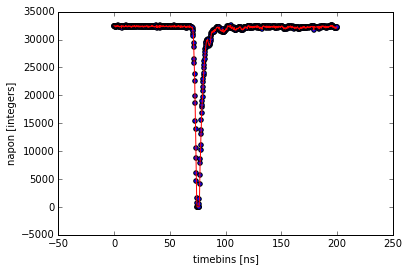

In [9]:
%matplotlib inline
x = vreme[0]
y = file_header["data_channel2"][0]
plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('napon [integers]')
plt.show()

grafik sa podacima istog kanala sa invertovanim vrednostima napona

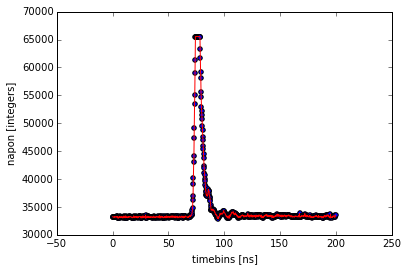

In [23]:
x = vreme[100]
y = -file_header["data_channel2"][100]
plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('napon [integers]')
plt.show()

2  - provera da li ima signala u svim kanalima

In [33]:
#ovde trazimo max vrednosti u svakom kanalu
def vrednost_maksimuma_u_kanalu(kanal):
    return np.max(kanal)
invert_kanal2 = - kanal2
kanal2_= np.apply_along_axis(vrednost_maksimuma_u_kanalu, 1, invert_kanal2[:])
invert_kanal3 = - kanal3
kanal3_= np.apply_along_axis(vrednost_maksimuma_u_kanalu, 1, invert_kanal3[:])

In [43]:
# kanal sa najmanjom maksimalnom vrednosti
min(kanal2_), min(kanal3_)

(36255, 33693)

In [44]:
#indeks kanala sa najmanjom maksimalnom vrednosti
np.nonzero(kanal2_ == 36255), np.nonzero(kanal3_ == 33693)

((array([16834], dtype=int64),), (array([123963], dtype=int64),))

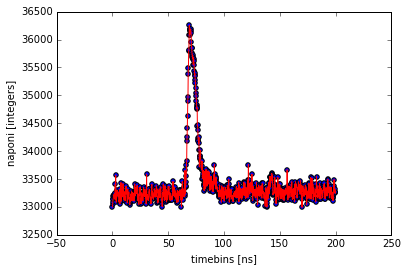

In [72]:
#grafik kanala 2 sa najmanjom maksimalnom vrednosti
x = vreme[16834]
y = - kanal2[16834]
plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('naponi [integers]')
plt.show()

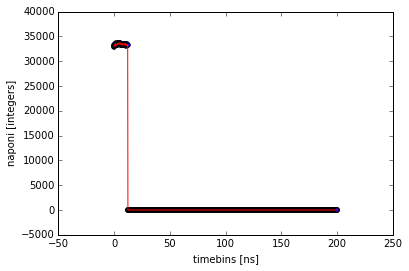

In [71]:
#grafik kanala 3 sa najmanjom maksimalnom vrednosti
x = vreme[123963]
y = - kanal3[123963]
plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('naponi [integers]')
plt.show()

In [48]:
min(kanal3_[:123963]), min(kanal3_[123964:])

(36137, 36504)

na osnovu slike kanala sa sumom koju si mi poslao,
zakljucio sam da je samo kanala 3 u 123963em iventu prazan,
jer da ih je bilo ne bih dobio ovakav grafik za signal iz kanala sa najmanjim maksimumom napona

In [75]:
#ivent broj 123963 ne koristiti

3 - Provera da li je doslo do saturacije u nekom kanalu

In [144]:
def saturacija(element_kanala):
    return np.count_nonzero(element_kanala == max(element_kanala)) > 1

In [167]:
kanal3_saturacija= np.apply_along_axis(saturacija, 1, invert_kanal3[:])

In [168]:
np.count_nonzero(kanal3_saturacija == max(kanal3_saturacija))

6110

In [169]:
indeksi_saturisanih_kanal3 = np.where(kanal3_saturacija == True)

In [170]:
kanal2_saturacija= np.apply_along_axis(saturacija, 1, invert_kanal2[:])

In [171]:
np.count_nonzero(kanal2_saturacija == max(kanal2_saturacija))

34300

In [172]:
indeksi_saturisanih_kanal2 = np.where(kanal2_saturacija == True)

In [186]:
#indeksi kanala koje treba brisati
indeksi_za_brisanje = np.setxor1d(indeksi_saturisanih_kanal2,indeksi_saturisanih_kanal3)

In [187]:
len(indeksi_za_brisanje)

35770

In [128]:
#primer za brisanje

s = np.array([[1, 2, 3, 4],[1, 1, 1, 1],[5, 5, 5, 5],[3, 3, 4, 4,]])
s.shape

(4L, 4L)

In [129]:
indeks_za_brisanje = (1, 2)
s = np.delete(s, (indeks), axis=0)

In [130]:
s

array([[1, 2, 3, 4],
       [3, 3, 4, 4]])

4 - digitalno filtriranje

In [76]:
@jit
def filtriranje(nefiltrirani):
    filtrirani = np.ones(1024)
    y2, y1 = nefiltrirani[:2]
    filtrirani[0] = nefiltrirani[0]
    filtrirani[1] = nefiltrirani[1]
    for i in range(2,1024):
        y = 0.20657 * nefiltrirani[i] + 0.41314 * nefiltrirani[i-1] \
        + 0.20657 * nefiltrirani[i-2] + 0.36953 * y1 - 0.19582 * y2
        filtrirani[i] = y
        y2 = y1
        y1 = y
    return filtrirani

In [9]:
kanal2_filtrirani = np.apply_along_axis(filtriranje, 1, kanal2[:])

In [13]:
kanal3_filtrirani = np.apply_along_axis(filtriranje, 1, kanal3[:])

4 - eliminisanje spajkova

In [10]:
@jit
def eliminisanje_spajkova(kanal):
    #usrednjavanje sa 6 tacaka levo i 6 desno
    for i in range(6, 1018):
        kanal[i] = (kanal[i-6] + kanal[i-5] + kanal[i-4] + kanal[i-3] + \
                    kanal[i-2] + kanal[i-1] + kanal[i] + kanal[i+1] + kanal[i+2] + \
                    kanal[i+3] + kanal[i+4] + kanal[i+5] + kanal[i+6]) / 13
    return kanal
    
    


In [11]:
kanal2_filtrirani_i_eliminisani_spajkovi = np.apply_along_axis(eliminisanje_spajkova, 1, kanal2_filtrirani[:])

In [14]:
kanal3_filtrirani_i_eliminisani_spajkovi = np.apply_along_axis(eliminisanje_spajkova, 1, kanal3_filtrirani[:])

5 - maksimum pika

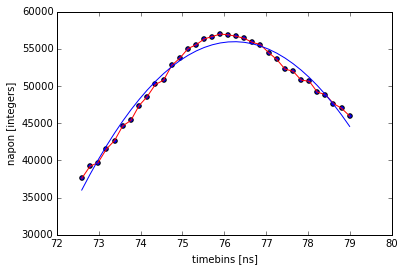

In [118]:
import numpy.polynomial.polynomial as poly

broj = 19
#index maksimuma
maksimum = (-file_header["data_channel2"][broj]).argmax()

x = vreme[broj][maksimum - 17:maksimum + 17]
y = -file_header["data_channel2"][broj][maksimum - 17:maksimum + 17]
coefs = poly.polyfit(x, y, 2)
ffit = poly.polyval(x, coefs)

plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('napon [integers]')
plt.plot(x, ffit)

In [107]:
max_y = max(ffit)  # Find the maximum y value
max_x = x[ffit.argmax()]  # Find the x value corresponding to the maximum y value
print max_x, max_y

76.4756 66333.5187314


In [15]:
f.close()

In [60]:
#%reset_selective -f file_header